In [24]:
import numpy as np
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt
import time
import math
import sys

In [3]:
polygon_files = ["perim_data/east_troublesome_ts.gpkg"]
data = gpd.read_file(polygon_files[0])
print(data.head)

<bound method NDFrame.head of             sim  id                     dates  \
0    experiment   1 2020-10-22 11:00:00+00:00   
1    experiment   2 2020-10-22 11:20:00+00:00   
2    experiment   3 2020-10-22 11:40:00+00:00   
3    experiment   4 2020-10-22 12:00:00+00:00   
4    experiment   5 2020-10-22 12:20:00+00:00   
..          ...  ..                       ...   
388        a_op   3 2020-10-24 01:30:30+00:00   
389        a_op   4 2020-10-24 13:29:52+00:00   
390        a_op   5 2020-10-24 20:37:52+00:00   
391        a_op   6 2020-10-24 22:45:47+00:00   
392        a_op   7 2020-10-25 01:29:47+00:00   

                                              geometry  
0    MULTIPOLYGON (((438538.814 4466012.402, 438538...  
1    MULTIPOLYGON (((438483.316 4466040.804, 438483...  
2    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
3    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
4    MULTIPOLYGON (((438455.678 4466096.886, 438455...  
..                                     

In [3]:
print(data.shape)

(393, 4)


In [31]:
idx = 1
print(type(data.iloc[idx]["geometry"]))
print(len(data.iloc[idx]["geometry"].geoms))

print(data.iloc[idx]["geometry"].geoms[0].area)
#print(data.iloc[0]["geometry"].geoms[0].exterior)

print(len(data.iloc[idx]["geometry"].geoms[0].exterior.coords))
simple_poly = data.iloc[idx]["geometry"].geoms[0].simplify(0.05).exterior
print(len(simple_poly.coords))
#print(simple_poly)

<class 'shapely.geometry.multipolygon.MultiPolygon'>
1
411290.8838642978
2684
466


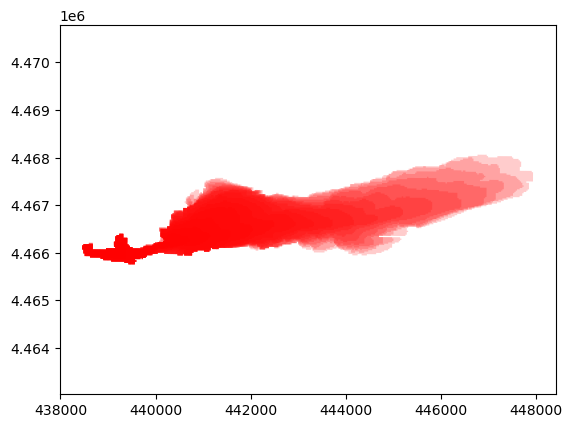

In [94]:
fig, axs = plt.subplots()
axs.set_aspect('equal', 'datalim')
runfor = 20
for i in range(runfor):
    xsi, ysi = data.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.xy   
    axs.fill(xsi, ysi, alpha=0.2, fc='r', ec='none')
#xs1, ys1 = data.iloc[1]["geometry"].geoms[0].simplify(0.05).exterior.xy 

plt.show()

In [5]:
### evaluate distance
def dist(a, b):
    return ((a[0] - b[0]) ** 2) + ((a[1] - b[1]) ** 2)

### algorithm 1 -- naive max over min distances nearest neighbors
def nn_basic(gpd_dataset, stopat):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()

    ### get original inner perimeter
    step_n_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].exterior.coords
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        if i % 10 == 0:
            print("basic", i)

        step_n_0 = step_n_1
        step_n_1 = gpd_dataset.iloc[i]["geometry"].geoms[0].exterior.coords
        step_pairs = [] ### step_n_1 point with minimum distance
        step_dists = []  ### distance to nearest step_n_1 point
        ### iterate over inner points
        for j in range(len(step_n_0)):
            rolling_closest = None
            rolling_dist = float("inf")
            ### iterate over outer points to find closest
            for k in range(len(step_n_1)):
                tdist = dist(step_n_0[j], step_n_1[k])
                if tdist < rolling_dist:
                    rolling_dist = tdist
                    rolling_closest = k
            step_pairs.append(rolling_closest)
            step_dists.append(rolling_dist)

        step_orig = np.argmax([step_dists])
        step_max = step_dists[step_orig]
        step_dest = step_pairs[step_orig]
        #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([step_orig, step_dest])
        result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [51]:
### algorithm 2 -- naive min/max knn with simplified geometries
def nn_simplified(gpd_dataset, stopat):
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()
    
    ### get original inner perimeter and simplify geometry with tolerance 0.05
    step_n_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].simplify(0.05).exterior.coords
    ### iterate over time steps
    for i in range(1, min(gpd_dataset.shape[0], stopat)):
        if i % 10 == 0:
            print("simplified", i)

        ### move outer geometry to inner geometry
        step_n_0 = step_n_1
        ### get next outer geometry and simplify with tolerance 0.05
        step_n_1 = gpd_dataset.iloc[i]["geometry"].geoms[0].simplify(0.05).exterior.coords
        step_pairs = [] ### step_n_1 point with minimum distance
        step_dists = []  ### distance to nearest step_n_1 point
        ### iterate over inner points
        for j in range(len(step_n_0)):
            rolling_closest = None
            rolling_dist = float("inf")
            ### iterate over outer points to find closest
            for k in range(len(step_n_1)):
                tdist = dist(step_n_0[j], step_n_1[k])
                if tdist < rolling_dist:
                    rolling_dist = tdist
                    rolling_closest = k
            step_pairs.append(rolling_closest)
            step_dists.append(rolling_dist)

        step_orig = np.argmax([step_dists])
        step_max = step_dists[step_orig]
        step_dest = step_pairs[step_orig]
        #step_vector = (step_n_1[step_pair][0] - step_n_0[step_orig][0], step_n_1[step_pair][1] - step_n_0[step_orig][1])
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([step_orig, step_dest])
        result_dist.append(step_max)

    return result_pair, result_dist, result_time

In [93]:
stopat = 40
### compare methods
print("comparing basic")
#nnb_res = nn_basic(data, stopat)
print("comparing simplified basic")
nns_res = nn_simplified(data, stopat)

comparing basic
comparing simplified basic
simplified 10
simplified 20


ValueError: x and y must have same first dimension, but have shapes (9,) and (392,)

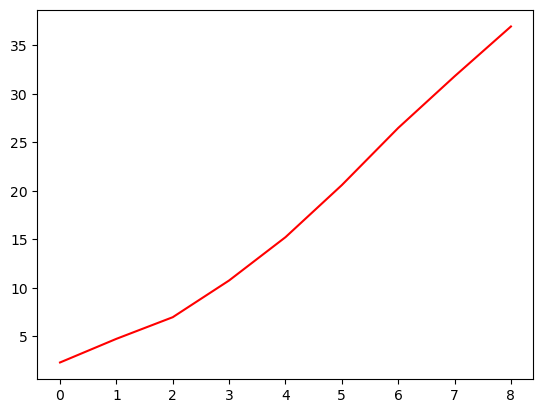

In [92]:
### step one -- compare times...
fig, axs = plt.subplots()
itersteps = np.arange(len(nnb_res[2]))
#axs.plot(itersteps, nnb_res[2], color="red", label="basic")
axs.plot(itersteps, nns_res[2], color="green", label="simplified")
axs.legend()

plt.show()

In [56]:
### idea -- some get bounding boxes, grid out, bin, establish which are closest...
### i didn't hear who you said I should talk to about transformers ...

max_bins = 200
index = 20

def nn_binned(gpd_dataset, stopat, max_bins=200):
    root2 = round(math.sqrt(2), 5)
    result_time = [] ### time taken to compute each step
    result_pair = [] ### pair of points with max min distance
    result_dist = [] ### distance between points
    ### start timer
    time_1 = time.time()
    
    ### get original inner perimeter and simplify geometry with tolerance 0.05
    step_1 = gpd_dataset.iloc[0]["geometry"].geoms[0].simplify(0.05).exterior
    ### iterate over time steps
    for index in range(1, min(gpd_dataset.shape[0], stopat)):
        if index % 10 == 0:
            print("simplified", i)
        ### need to get this from shapes
        ### UL x, y LR x, y
        step_0 = step_1
        step_1 = gpd_dataset.iloc[index]["geometry"].geoms[0].simplify(0.05).exterior
        bbox_0 = step_0.bounds
        bbox_1 = step_1.bounds
        bbox = (min(bbox_0[0], bbox_1[0]), min(bbox_0[1], bbox_1[1]), max(bbox_0[2], bbox_1[2]), max(bbox_0[3], bbox_1[3]))
        bins_x = math.ceil((bbox[2] - bbox[0])/max_bins)
        bins_y = math.ceil((bbox[3] - bbox[1])/max_bins)
        bin_res = max(bins_x, bins_y)
        grid_size = (math.ceil((bbox[2] - bbox[0])/bin_res), math.ceil((bbox[3] - bbox[1])/bin_res))
        grid_spatial = (grid_size[0] * bin_res, grid_size[1] * bin_res)
        grid_offset = ((grid_spatial[0] - (bbox[2] - bbox[0]))/2, (grid_spatial[1] - (bbox[3] - bbox[1]))/2)
        ### now make np array w/ coarser side...
        bins_0 = np.zeros(grid_size, dtype=object)
        occu_0 = np.zeros(grid_size, dtype=bool)
        bins_1 = np.zeros(grid_size, dtype=object)
        occu_1 = np.zeros(grid_size, dtype=bool)
        for i in range(grid_size[0]):
            for j in range(grid_size[1]):
                bins_0[i, j] = [] 
                bins_1[i, j] = []

        lower = (bbox[0] - grid_offset[0], bbox[1] - grid_offset[1])
        s0c = step_0.coords
        s1c = step_1.coords

        for i in range(len(s0c)):
            ### bin inner layer
            s0c_ids = (int((s0c[i][0]-lower[0])//bin_res), (int(s0c[i][1]-lower[1])//bin_res))
            bins_0[s0c_ids[0], s0c_ids[1]].append(i)
            occu_0[s0c_ids[0], s0c_ids[1]] = True

        for i in range(len(s1c)):
            ### bin outer layer
            s1c_ids = (int((s1c[i][0]-lower[0])//bin_res), (int(s1c[i][1]-lower[1])//bin_res))
            bins_1[s1c_ids[0], s1c_ids[1]].append(i)
            occu_1[s1c_ids[0], s1c_ids[1]] = True

        ### get list of occupied bins
        ocid_0 = np.argwhere(occu_0 == True)
        ocid_1 = np.argwhere(occu_1 == True) 

        sample_pair = None
        sample_dist = float("-inf")

        ### do root2 rings... focus on points in outer perim
        for occu_loc in ocid_1:
            ### expand out until we find all squares with UL distance of 2sqrt(2) of the closest
            root2_dist = max_bins ### needs some work...?
            root2_set = True
            ring = 0
            ring_sqs = None
            ring_offset = None
            while ring < root2_dist:
                temp = np.argwhere(occu_0[max(occu_loc[0]-ring, 0): min(occu_loc[0]+ring+1, grid_size[0] - 1), 
                                        max(occu_loc[1]-ring, 0): min(occu_loc[1]+ring+1, grid_size[1] - 1)]==True)
                if len(temp) > 0 and root2_set:
                    root2_dist = math.ceil(math.sqrt(2) * (ring + 1)) + 1
                    root2_set = False
                if ring+1 >= root2_dist and not root2_set:
                    ring_sqs = temp
                    ring_offset = [max(occu_loc[0]-ring, 0), max(occu_loc[1]-ring, 0)]
                ring += 1
        
            ### for each outer box (occu_loc) we have a series of points (len(bins_1[][])) -- 
            ###     for each point we have a series of inner boxes (ring_sqs[][][i/j])
            ###         for each inner box we have a series of points --- measure distances and find min
            spair = None
            sdist = float("-inf")
            n_checks = 0
            for k in range(len(bins_1[occu_loc[0], occu_loc[1]])):
                tpair = None
                tdist = float("inf")
                for i in range(len(ring_sqs)):
                    temp_box_0 = bins_0[ring_sqs[i][0] + ring_offset[0], ring_sqs[i][1] + ring_offset[1]]
                    #print(len(temp_box_0))
                    for l in range(len(temp_box_0)):
                        temp_dist = dist(s1c[bins_1[occu_loc[0], occu_loc[1]][k]], s0c[temp_box_0[l]])
                        if temp_dist < tdist:
                            tpair = (temp_box_0[l], bins_1[occu_loc[0], occu_loc[1]][k])
                            tdist = temp_dist
                        n_checks += 1
                ### now having compared all inner samples to this point...
                if tdist > sdist:
                    spair = tpair
                    sdist = tdist
            if sdist > sample_dist:
                sample_dist = sdist
                sample_pair = spair
        time_0 = time_1
        time_1 = time.time()
        result_time.append(time_1 - time_0)
        result_pair.append([s0c[sample_pair[0]], s1c[sample_pair[1]]])
        result_dist.append(sample_dist)
    return result_pair, result_dist, result_time
"""        if False:
            freqmap = np.zeros(grid_size)
            for i in range(grid_size[0]):
                for j in range(grid_size[1]):
                    freqmap[i, j] = len(bins_0[i][j]) + len(bins_1[i][j])
            plt.imshow(freqmap.transpose(), origin='lower')
            plt.plot([(s0c[sample_pair[0]][0]-lower[0])//bin_res, (s1c[sample_pair[1]][0]-lower[0])//bin_res], 
                    [(s0c[sample_pair[0]][1]-lower[1])//bin_res, (s1c[sample_pair[1]][1]-lower[1])//bin_res], color="r")
            plt.show()"""

'        if False:\n            freqmap = np.zeros(grid_size)\n            for i in range(grid_size[0]):\n                for j in range(grid_size[1]):\n                    freqmap[i, j] = len(bins_0[i][j]) + len(bins_1[i][j])\n            plt.imshow(freqmap.transpose(), origin=\'lower\')\n            plt.plot([(s0c[sample_pair[0]][0]-lower[0])//bin_res, (s1c[sample_pair[1]][0]-lower[0])//bin_res], \n                    [(s0c[sample_pair[0]][1]-lower[1])//bin_res, (s1c[sample_pair[1]][1]-lower[1])//bin_res], color="r")\n            plt.show()'

In [53]:
stopat = 40
### compare methods
#print("comparing basic")
#nnb_res = nn_basic(data, stopat)
print("comparing simplified basic")
nns_res = nn_simplified(data, stopat)

comparing simplified basic
simplified 10
simplified 20
simplified 30


In [57]:
print("comparing binned (200)")
bin_res = nn_binned(data, stopat, 200)

comparing binned (200)
simplified 29
simplified 16
simplified 9


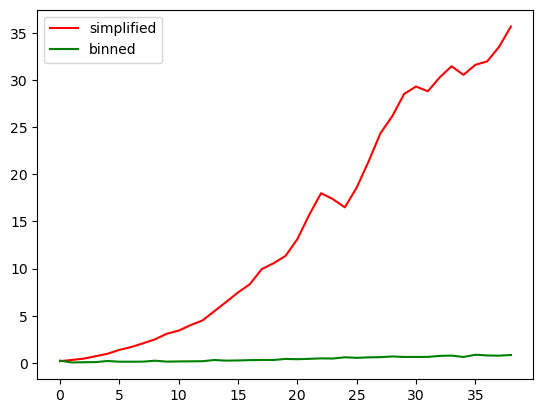

In [58]:
### step one -- compare times...
fig, axs = plt.subplots()
itersteps_1 = np.arange(len(nns_res[2]))
itersteps_2 = np.arange(len(bin_res[2]))
axs.plot(itersteps, nns_res[2], color="red", label="simplified")
axs.plot(itersteps, bin_res[2], color="green", label="binned")
axs.legend()

plt.show()